In [205]:
#all imports for datacleaning
import pandas as pd
from datetime import datetime
import glob
import os

from sklearn.pipeline import Pipeline



In [206]:
#read in the data
path = "data/"
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_kick = pd.concat(li, axis=0, ignore_index=True)


## Some data cleaning

In [207]:
#first, we check for duplicates
print("total number of entries:", df_kick.id.count())
print("number of entries with unique ids:", df_kick.id.nunique())
print("double entries:", df_kick.id.count()-df_kick.id.nunique())

total number of entries: 209222
number of entries with unique ids: 182264
double entries: 26958


So, we have 26958 entries that are not unique.

In [208]:
#remove these entries
df_kick.drop_duplicates(subset=['id'],inplace=True)

In [209]:
#first drop redundant, unnecessary or almost empty collumns
columns_drop = ['id', 'photo', 'slug', 'currency_symbol', 'fx_rate', 'currency_trailing_code', 'usd_type', 'urls', 'source_url', 'converted_pledged_amount','friends','is_starred','is_backing','permissions','current_currency']
df_kick = df_kick.drop(columns_drop, axis=1)

In [210]:
# Changing format of the timestamp columns
timestamp_columns = ['deadline', 'created_at', 'launched_at', 'state_changed_at']

for col in timestamp_columns:
    df_kick[col] = df_kick[col].apply(datetime.fromtimestamp)

In [211]:
#check for remaining null-values
df_kick.isnull().sum()

backers_count              0
blurb                      8
category                   0
country                    0
created_at                 0
creator                    0
currency                   0
deadline                   0
disable_communication      0
goal                       0
is_starrable               0
launched_at                0
location                 224
name                       0
pledged                    0
profile                    0
spotlight                  0
staff_pick                 0
state                      0
state_changed_at           0
static_usd_rate            0
usd_pledged                0
dtype: int64

We will drop the missing "blurb" entries, since this is important information we want to have. For now, we'll ignore the missing "location" values as this column might be redundant anyway.

In [212]:
#drop missing "blurb" values
df_kick = df_kick.dropna(subset=["blurb"])
#reset index
df_kick.reset_index(drop=True, inplace=True)

Our analysis and research showed, that the "goal" is in the foreign currency. Since we want to compare all projects in USD, we transform "goal" to USD using the given "static_usd_rate".

In [213]:
#create goal_usd
df_kick["goal_usd"] = df_kick["goal"] * df_kick["static_usd_rate"]

In [214]:
#now we remove the redundant information on the foreign currency
del_columns = ["goal", "currency", "static_usd_rate"]
df_kick = df_kick.drop(del_columns, axis=1)

Possible states are live, successful, canceled, failed and suspended.
We drop live states, since they're not finished.
We also drop suspended states, as they are only 600 and we don't know exactly why they have been suspended.
We add canceled to failed, since for our use case the outcome is identical.

In [215]:
#drop the rows
df_kick = df_kick.drop(df_kick[df_kick["state"]=="suspended"].index)
df_kick = df_kick.drop(df_kick[df_kick["state"]=="live"].index)
df_kick.reset_index(drop=True, inplace=True)

In [216]:
#put "canceled" into the "failed" category
df_kick.state = df_kick.state.replace("canceled","failed")

Since state is the feature we want to predict, we transform it into a 1/0 categorical variable.

In [217]:
df_kick.state = df_kick.state.replace("successful", 1)
df_kick.state = df_kick.state.replace("failed", 0)
df_kick.state.unique()

array([1, 0])

## Descriptive Statistics

In [218]:
#import plot modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<AxesSubplot:xlabel='state', ylabel='count'>

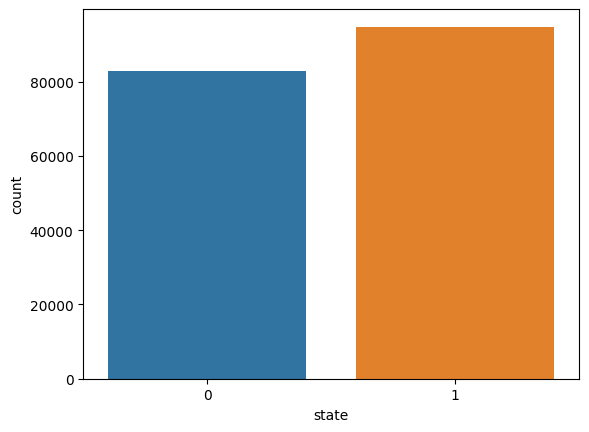

In [219]:
#check how balanced our dataset is
fig = plt.plot
sns.countplot(x=df_kick.state)

In [220]:
df_kick.info()
col_plot = ["pledged", "usd_pledged", "goal_usd"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177595 entries, 0 to 177594
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   backers_count          177595 non-null  int64         
 1   blurb                  177595 non-null  object        
 2   category               177595 non-null  object        
 3   country                177595 non-null  object        
 4   created_at             177595 non-null  datetime64[ns]
 5   creator                177595 non-null  object        
 6   deadline               177595 non-null  datetime64[ns]
 7   disable_communication  177595 non-null  bool          
 8   is_starrable           177595 non-null  bool          
 9   launched_at            177595 non-null  datetime64[ns]
 10  location               177371 non-null  object        
 11  name                   177595 non-null  object        
 12  pledged                177595 non-null  floa

In [221]:
# Plot distribution of features 
#features = df_kick.columns.tolist()
features = ["pledged", "usd_pledged", "goal_usd"]
#features.remove('Outcome')
'''
fig,ax = plt.subplots(3,3,figsize=(16,12))
count = 0
for item in features:
    sns.histplot(df_kick[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)
'''

"\nfig,ax = plt.subplots(3,3,figsize=(16,12))\ncount = 0\nfor item in features:\n    sns.histplot(df_kick[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')\n    count += 1\nax.flat[-1].set_visible(False)\nfig.tight_layout(pad=3)\n"

In [222]:
df_kick.shape

(177595, 20)

In [223]:
df_kick.head()

,backers_count,blurb,category,country,created_at,creator,deadline,disable_communication,is_starrable,launched_at,location,name,pledged,profile,spotlight,staff_pick,state,state_changed_at,usd_pledged,goal_usd
0,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",US,2017-08-02 16:28:13,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",2017-09-09 19:00:59,False,False,2017-08-10 19:00:59,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,1950.0,"{""id"":3094785,""project_id"":3094785,""state"":""ac...",True,False,1,2017-09-09 19:00:59,1950.000000,1000.0000
1,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",US,2012-09-30 08:45:33,"{""id"":323849677,""name"":""Electra"",""is_registere...",2013-06-12 07:03:15,False,False,2013-05-13 07:03:15,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",22404.0,"{""id"":359847,""project_id"":359847,""state"":""inac...",True,False,1,2013-06-12 07:03:15,22404.000000,15000.0000
2,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",GB,2017-01-07 10:11:11,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",2017-03-13 18:22:56,False,False,2017-01-12 19:22:56,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,136.0,"{""id"":2825329,""project_id"":2825329,""state"":""in...",False,False,0,2017-03-13 18:22:56,165.384934,12160.6569
3,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",US,2012-12-06 19:04:31,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",2013-01-09 21:32:07,False,False,2012-12-10 21:32:07,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,2820.0,"{""id"":417385,""project_id"":417385,""state"":""inac...",True,False,1,2013-01-09 21:32:07,2820.000000,2800.0000
4,35,Annapolis Chamber Players is a non-for profit ...,"{""id"":36,""name"":""Classical Music"",""slug"":""musi...",US,2014-10-24 19:35:50,"{""id"":682189804,""name"":""Annapolis Chamber Play...",2015-05-02 04:25:46,False,False,2015-04-02 04:25:46,"{""id"":2354877,""name"":""Annapolis"",""slug"":""annap...",Annapolis Chamber Music Project,3725.0,"{""id"":1465941,""project_id"":1465941,""state"":""in...",True,False,1,2015-05-02 04:25:46,3725.000000,3500.0000


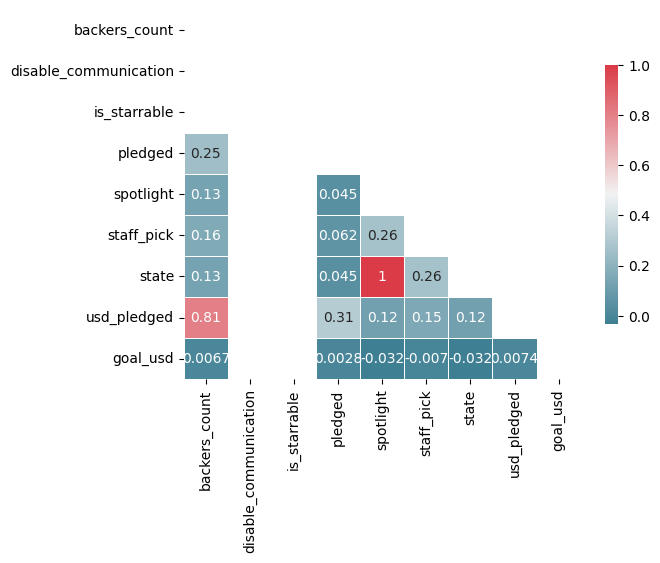

In [224]:
col_plot = ["backers_count", "pledged", "usd_pledged", "goal_usd","state","country"]

# Compute correlations
#correlations = df_kick[col_plot].corr()
correlations = df_kick.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, annot=True,
            linewidths=.5, cbar_kws={"shrink": .7});

In [225]:
df_kick.columns

Index(['backers_count', 'blurb', 'category', 'country', 'created_at',
       'creator', 'deadline', 'disable_communication', 'is_starrable',
       'launched_at', 'location', 'name', 'pledged', 'profile', 'spotlight',
       'staff_pick', 'state', 'state_changed_at', 'usd_pledged', 'goal_usd'],
      dtype='object')

In [226]:
df_kick.location.nunique()

15101

In [227]:
df_kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177595 entries, 0 to 177594
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   backers_count          177595 non-null  int64         
 1   blurb                  177595 non-null  object        
 2   category               177595 non-null  object        
 3   country                177595 non-null  object        
 4   created_at             177595 non-null  datetime64[ns]
 5   creator                177595 non-null  object        
 6   deadline               177595 non-null  datetime64[ns]
 7   disable_communication  177595 non-null  bool          
 8   is_starrable           177595 non-null  bool          
 9   launched_at            177595 non-null  datetime64[ns]
 10  location               177371 non-null  object        
 11  name                   177595 non-null  object        
 12  pledged                177595 non-null  floa

## Baseline Model
Our baseline model is to simply predict the positive outcome (state=successful) by the amount of people investing in a project (backers_count)

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score


y = df_kick.state
X = df_kick[["backers_count"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
precision_score(y_pred_baseline, y_test)

0.7546642774322757

In [229]:
df_kick.goal_usd.describe()

count    1.775950e+05
mean     4.431976e+04
std      1.164770e+06
min      1.000000e-02
25%      1.500000e+03
50%      5.000000e+03
75%      1.433185e+04
max      1.523501e+08
Name: goal_usd, dtype: float64

In [230]:
y_pred = []

for i in df_kick.goal_usd:
    if i < 20000:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [231]:
precision_score(y_pred, y)

0.8852804946243367

## Preprocessing

In [232]:
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json
import re


df_kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177595 entries, 0 to 177594
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   backers_count          177595 non-null  int64         
 1   blurb                  177595 non-null  object        
 2   category               177595 non-null  object        
 3   country                177595 non-null  object        
 4   created_at             177595 non-null  datetime64[ns]
 5   creator                177595 non-null  object        
 6   deadline               177595 non-null  datetime64[ns]
 7   disable_communication  177595 non-null  bool          
 8   is_starrable           177595 non-null  bool          
 9   launched_at            177595 non-null  datetime64[ns]
 10  location               177371 non-null  object        
 11  name                   177595 non-null  object        
 12  pledged                177595 non-null  floa

In [233]:
num_features = ["backers_count", "goal_usd"]
cat_features = ["category_clean", "country"]

df_kick.creator

0         {"id":723886115,"name":"Lisa Vollrath","slug":...
1         {"id":323849677,"name":"Electra","is_registere...
2         {"id":196281496,"name":"Artur Ordijanc (delete...
3         {"id":1178460181,"name":"Dawn Johnston","is_re...
4         {"id":682189804,"name":"Annapolis Chamber Play...
                                ...                        
177590    {"id":356376150,"name":"Pepper Proud","is_regi...
177591    {"id":1412154830,"name":"Lester Arias is ARIA ...
177592    {"id":891767476,"name":"Doug Stienstra","is_re...
177593    {"id":307076473,"name":"Timothy Vernor","is_re...
177594    {"id":1718677513,"name":"Article","slug":"arti...
Name: creator, Length: 177595, dtype: object

In [234]:
df_kick["category_clean"] = [re.sub("/.*","", json.loads(entry)["slug"]) for entry in df_kick.category ]
df_kick.category_clean.nunique()

df_kick["creator_clean"] = [json.loads(re.sub(",.*" , "}", entry))["id"] for entry in df_kick.creator ]
df_kick.creator_clean.value_counts()



2104052526    72
957058942     59
978911160     52
2039317553    36
1323060510    35
              ..
90306855       1
993941701      1
411112317      1
776440178      1
891767476      1
Name: creator_clean, Length: 153529, dtype: int64

In [235]:
# Pipline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    #('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    #('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [236]:
#from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTranformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [237]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [238]:
temp  = cat_features + num_features

X = df_kick[temp]

y = df_kick["state"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [244]:
pipe_logreg.fit(X_test, y_test)

y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

In [245]:
y_pred_log_reg = pipe_logreg.predict(X_test)

In [247]:
print(precision_score(y_test, y_pred_log_reg))

0.9289040527456315
